## Significance levels and Bootstrapping

This notebook is for testing bootstrapping method for computing significance levels and confidence intervals. These are further compared against standard method, which assumes guassian distribution. 

In [1]:
import numpy as np
import scipy.stats as sc
import xarray as xr
import xskillscore as xs
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from climpred import HindcastEnsemble
#import climpred

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', orien='vertical', colorbar=True,
            y_lab = True, x_lab = True, grid_line = True):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    if(colorbar==True):
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=1.0, orientation=orien)
        cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    if(grid_line == True):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    gl.ylocator = mticker.FixedLocator([70, 60, 50, 40, 30])
    gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0])
    
    if(y_lab==False):
        gl.ylocator = mticker.FixedLocator([])
    if(x_lab==False):
        gl.xlocator = mticker.FixedLocator([])
    
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=12)
    return p

In [3]:
# Read data

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['mlotst', 'tos', 'tauu', 'hfds', 'Heat_Budget_new']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

print(ds_NAOp)

<xarray.Dataset>
Dimensions:            (j: 321, i: 361, comp: 114, time: 101, lat: 99, lon: 432)
Coordinates:
  * j                  (j) int32 780 781 782 783 784 ... 1097 1098 1099 1100
  * i                  (i) int32 810 811 812 813 814 ... 1167 1168 1169 1170
    latitude           (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
  * lat                (lat) float64 20.28 20.83 21.39 ... 73.61 74.17 74.72
  * lon                (lon) float64 0.0 0.8333 1.667 2.5 ... 357.5 358.3 359.2
    nav_lat            (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lon            (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
Dimensions without coordinates: comp, time
Data variables:
    mlotst             (comp, time, j, i) float32 dask.array<chunksize=(114, 1, 321, 361), meta=np.ndarray>
    tos                (comp, time, j, i) float32 dask.arra

In [4]:
%time T_mean = ds_NAOp['tos'].isel(i=slice(0, 5), j=slice(200,205)).mean(['i','j']).compute()

CPU times: user 711 ms, sys: 10.8 s, total: 11.5 s
Wall time: 9min


## Bootstrapping with scipy

In [14]:
data = [7, 9, 10, 10, 12, 14, 15, 16, 16, 17, 19, 20, 21, 21, 23]
data = (data,)

tmp = (T_mean,)

bootstrap_ci = sc.bootstrap(tmp, np.mean, confidence_level=0.9, axis=0, n_resamples=299,
                             random_state=None)

In [15]:
print(bootstrap_ci.confidence_interval[0].shape, bootstrap_ci.confidence_interval[1].shape)
#print(bootstrap_ci.standard_error)
#print(np.mean(data), np.mean(data) + bootstrap_ci.standard_error * 1.96)

(101,) (101,)


In [16]:
bootstrap_ci.confidence_interval[0]

array([-3.85669393e-01, -8.92392719e-02, -7.08748428e-03, -4.77291822e-03,
       -3.27230613e-03, -1.54882829e-04, -2.93051227e-02, -3.30029228e-02,
       -1.36813548e-01, -8.74991374e-02, -6.98710193e-02, -2.66358422e-01,
       -3.39911825e-01, -9.38672201e-02, -1.66454488e-02, -1.66341669e-02,
       -1.73314704e-02, -4.14021348e-02, -1.03461627e-01, -2.59421741e-01,
       -5.66265182e-01, -6.42831112e-01, -4.58830738e-01, -4.47955299e-01,
       -3.48355434e-01, -6.13757319e-02, -1.36439386e-02, -1.16511242e-02,
       -1.00778992e-02, -1.34472275e-02, -6.42163732e-02, -3.05934073e-01,
       -3.09190218e-01, -2.81714807e-01, -1.84295902e-01, -2.84187889e-01,
       -3.09766229e-01, -4.15400483e-02, -3.79318933e-03, -2.69156655e-03,
       -1.18792473e-03, -1.31357342e-02, -4.19840244e-02, -1.61980749e-01,
       -3.52605685e-01, -2.79884850e-01, -2.41707863e-01, -2.89997289e-01,
       -2.59816272e-01, -5.36151029e-02, -8.30827048e-03, -6.96704014e-03,
       -5.74891069e-03, -

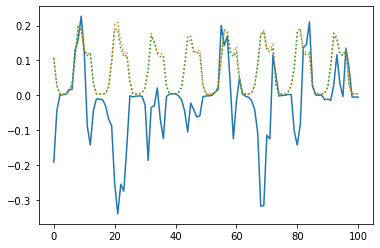

In [17]:
plt.plot(T_mean.mean('comp'))
#plt.plot(bootstrap_ci.confidence_interval[0], ls = '--')
#plt.plot(bootstrap_ci.confidence_interval[1], ls = '--')
plt.plot(bootstrap_ci.standard_error, ls = ':')
plt.plot(T_mean.std('comp')/np.sqrt(114), ls = ':')

In [10]:
T_mean.shape

(114, 101)

In [47]:
data = [7, 9, 10, 10, 12, 14, 15, 16, 16, 17, 19, 20, 21, 21, 23]
data = (data,)

tmp = (ds_NAOp['tauu'].sel(lat=slice(45,50), lon = slice(320, 340)).isel(time=14),)
#tmp = ds_NAOp['tauu'].sel(lat=slice(45,50), lon = slice(320, 340)).isel(time=14)

bootstrap_ci = sc.bootstrap(tmp, statistic=np.mean, confidence_level=0.9, axis=0, n_resamples=999, vectorized=True,
                             random_state=1, method='BCa')

In [48]:
tmp

(<xarray.DataArray 'tauu' (comp: 114, lat: 9, lon: 25)>
 dask.array<getitem, shape=(114, 9, 25), dtype=float32, chunksize=(114, 9, 25), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 45.28 45.83 46.39 46.94 47.5 48.06 48.61 49.17 49.72
   * lon      (lon) float64 320.0 320.8 321.7 322.5 ... 337.5 338.3 339.2 340.0
 Dimensions without coordinates: comp,)

In [49]:
print(bootstrap_ci.confidence_interval[0].shape, bootstrap_ci.confidence_interval[1].shape)
print(bootstrap_ci.standard_error.shape)

(9, 25) (9, 25)
(9, 25)


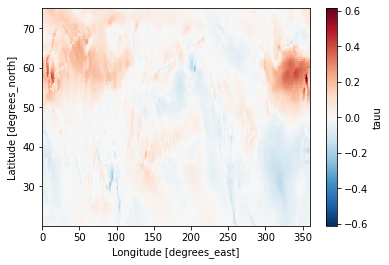

In [50]:
ds_NAOp['tauu'].isel(comp=0,time=15).plot()

In [9]:
ds_NAOp['tauu'].sel(lat=slice(45,50), lon = slice(320, 340)).isel(time=14).nbytes/1e3

102.6

In [14]:
tmp = xr.Dataset()
tmp['tau'] = ds_NAOp['tauu'].sel(lat=slice(45,50), lon = slice(320, 340)).isel(time=14)
tmp['ste'] = xr.DataArray(data = bootstrap_ci.standard_error, dims=['lat', 'lon'])
tmp['conint_lower'] = xr.DataArray(data = bootstrap_ci.confidence_interval[0], dims=['lat', 'lon'])
tmp['conint_upper'] = xr.DataArray(data = bootstrap_ci.confidence_interval[1], dims=['lat', 'lon'])

print(tmp)

<xarray.Dataset>
Dimensions:       (lat: 9, lon: 25, comp: 114)
Coordinates:
  * lat           (lat) float64 45.28 45.83 46.39 46.94 ... 48.61 49.17 49.72
  * lon           (lon) float64 320.0 320.8 321.7 322.5 ... 338.3 339.2 340.0
Dimensions without coordinates: comp
Data variables:
    tau           (comp, lat, lon) float32 dask.array<chunksize=(114, 9, 25), meta=np.ndarray>
    ste           (lat, lon) float32 0.00939 0.009218 ... 0.007901 0.007866
    conint_lower  (lat, lon) float64 0.04061 0.04214 0.04465 ... 0.1214 0.12
    conint_upper  (lat, lon) float64 0.07155 0.0725 0.07442 ... 0.1474 0.146


In [24]:
# Try xr_apply_unfunc 

def data_bootstrap(data, stat = np.mean, cf_lev = 0.95, num_sample = 1000):
    
    data = (data,)
    
    bootstrap_ci = sc.bootstrap(data, stat, confidence_level=cf_lev, axis=0, n_resamples=num_sample, vectorized=True,
                                random_state=1, method='BCa')
    
    return bootstrap_ci
                   

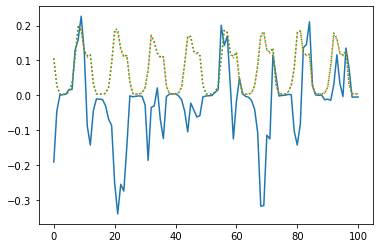

In [25]:
bootstrap_ci = data_bootstrap(T_mean, stat = np.mean, cf_lev = 0.95, num_sample = 1000)

plt.plot(T_mean.mean('comp'))
#plt.plot(bootstrap_ci.confidence_interval[0], ls = '--')
#plt.plot(bootstrap_ci.confidence_interval[1], ls = '--')
plt.plot(bootstrap_ci.standard_error, ls = ':')
plt.plot(T_mean.std('comp')/np.sqrt(114), ls = ':')

## Bootstrap with xskillscore

In [2]:
a = xr.DataArray(np.random.rand(3, 2), coords=[("time", np.arange(3)), ("x", np.arange(2))])

print(a)

<xarray.DataArray (time: 3, x: 2)>
array([[0.88370595, 0.10548982],
       [0.99777183, 0.45827104],
       [0.5713959 , 0.94205723]])
Coordinates:
  * time     (time) int64 0 1 2
  * x        (x) int64 0 1


In [5]:
a_resample = xs.resample_iterations_idx(a, 20, 'x') 

print(a_resample)

<xarray.DataArray (x: 2, time: 3, iteration: 20)>
array([[[0.88370595, 0.88370595, 0.88370595, 0.88370595, 0.10548982,
         0.88370595, 0.88370595, 0.88370595, 0.88370595, 0.88370595,
         0.10548982, 0.10548982, 0.10548982, 0.10548982, 0.88370595,
         0.88370595, 0.88370595, 0.10548982, 0.10548982, 0.10548982],
        [0.99777183, 0.99777183, 0.99777183, 0.99777183, 0.45827104,
         0.99777183, 0.99777183, 0.99777183, 0.99777183, 0.99777183,
         0.45827104, 0.45827104, 0.45827104, 0.45827104, 0.99777183,
         0.99777183, 0.99777183, 0.45827104, 0.45827104, 0.45827104],
        [0.5713959 , 0.5713959 , 0.5713959 , 0.5713959 , 0.94205723,
         0.5713959 , 0.5713959 , 0.5713959 , 0.5713959 , 0.5713959 ,
         0.94205723, 0.94205723, 0.94205723, 0.94205723, 0.5713959 ,
         0.5713959 , 0.5713959 , 0.94205723, 0.94205723, 0.94205723]],

       [[0.88370595, 0.88370595, 0.88370595, 0.88370595, 0.10548982,
         0.10548982, 0.88370595, 0.88370595, 0.8

In [8]:
print(a.mean('time'))

<xarray.DataArray (x: 2)>
array([0.59983258, 0.53951875])
Coordinates:
  * x        (x) int64 0 1


In [9]:
print(a_resample.mean('time'))

<xarray.DataArray (x: 2, iteration: 20)>
array([[0.5947057 , 0.60843175, 0.60843175, 0.60330487, 0.59983258,
        0.59983258, 0.60843175, 0.60843175, 0.5947057 , 0.60330487,
        0.59983258, 0.59123341, 0.5947057 , 0.59817798, 0.59123341,
        0.60843175, 0.59983258, 0.60843175, 0.60330487, 0.59817798],
       [0.42418728, 0.45531316, 0.45531316, 0.33998169, 0.53951875,
        0.53951875, 0.45531316, 0.45531316, 0.42418728, 0.33998169,
        0.53951875, 0.62372434, 0.42418728, 0.22465022, 0.62372434,
        0.45531316, 0.53951875, 0.45531316, 0.33998169, 0.22465022]])
Coordinates:
  * x          (x) int64 0 1
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19


In [15]:
num_sample = 10000
T_resam = xs.resample_iterations_idx(T_mean, num_sample, 'comp') 

In [16]:
print(T_resam)

<xarray.DataArray (comp: 114, time: 101, iteration: 10000)>
array([[[-2.21478507e-01, -3.18010032e-01, -1.01692092e+00, ...,
          7.10733116e-01, -1.94100952e+00, -8.75389099e-01],
        [ 2.65426964e-01, -1.59382120e-01, -2.73242414e-01, ...,
          1.63170576e-01, -1.12027168e-01, -1.21977530e-01],
        [ 6.30096570e-02,  2.44962573e-02,  2.94679794e-02, ...,
          1.23449564e-02, -3.00357747e-03, -2.08356772e-02],
        ...,
        [-5.19918613e-02,  4.82136011e-03, -1.06159888e-01, ...,
          8.44233856e-02,  1.44872665e-02,  6.60938025e-03],
        [-4.55597639e-02,  2.01536808e-02, -8.23711380e-02, ...,
          7.45175481e-02,  1.21850567e-02,  2.29914978e-04],
        [-4.76923771e-02,  1.76630020e-02, -7.66720995e-02, ...,
          7.55647644e-02,  1.73328519e-02,  1.31726265e-04]],

       [[-1.38765872e+00, -1.04293026e-01,  6.99688494e-01, ...,
          1.52519190e+00, -1.61104333e+00, -5.42270958e-01],
        [-1.60354838e-01, -1.59416318e-01, 

In [20]:
SE = (T_resam.mean(dim = 'comp')).std(dim = 'iteration')

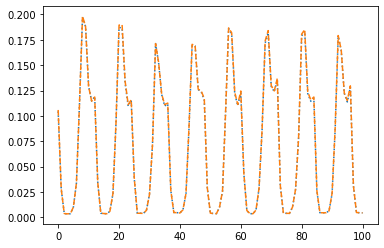

In [21]:
plt.plot(SE, ls = ':')
plt.plot(T_mean.std('comp')/np.sqrt(113), ls = '--')